# Autoencoders (AE) and Variational Autoencoders (VAE)

In this codebook, you will implement a standard autoencoder and train in on the famous [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset. We will then extend our model to be a VAE. Since the VAE is a generative model, we will sample new images from it. Parts of the code are already written, and sections where you need to write your own code are clearly marked (see example below). Outside of these block, you shouldn't *have* to change any code, but you are free to do so if you want. 

<!-- Furthermore, there will also be some theoretical questions for you to answer. Some of these will be fairly straight-forward, while others are more open-ended questions, where there is no single right answer. -->

While it might be tempting to use AI tools for solving these tasks, we believe that an important part of the learning process is *struggling* with a problem. We therefore recommend that you try solving it alone, and consult your classmates, before using AI.

**You will deliver the notebook with the output from each cell included (i.e. plots and print statements). You do not need to deliver anything else.**

## Loading the dataset

In the following cell, we will import the necessary libraries and load the MNIST dataset. We will also specify the device (CUDA if you have a GPU from NVIDIA, MPS if you have a newer Mac, otherwise the CPU). The biggest difference is that CUDA and MPS is significantly faster than running on the CPU (if you're only able to run on a CPU locally, it might be worth using either Google Colab or IDUN to run the notebook).

In [ ]:
%%capture
# run this cell to install the necessary libraries if you haven't already
%pip install torch torchvision tqdm matplotlib scikit-learn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import tqdm
import matplotlib.pyplot as plt

# Define the transform to convert the data to tensors and normalize it to be between 0 and 1
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        ]
    )

# Define the device to use
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Download and load the training data
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f"Using device: {device}")

Using device: cpu


If you are using the CPU, some cells like training the model might take a while. It is therefore recommended to use either Google Colab or IDUN to run the notebook.

The MNIST dataset is a collection of 28x28 grayscale images of handwritten digits. We use it since it is relatively small and easy to work with. Run the code below to see some of the images from the dataset.

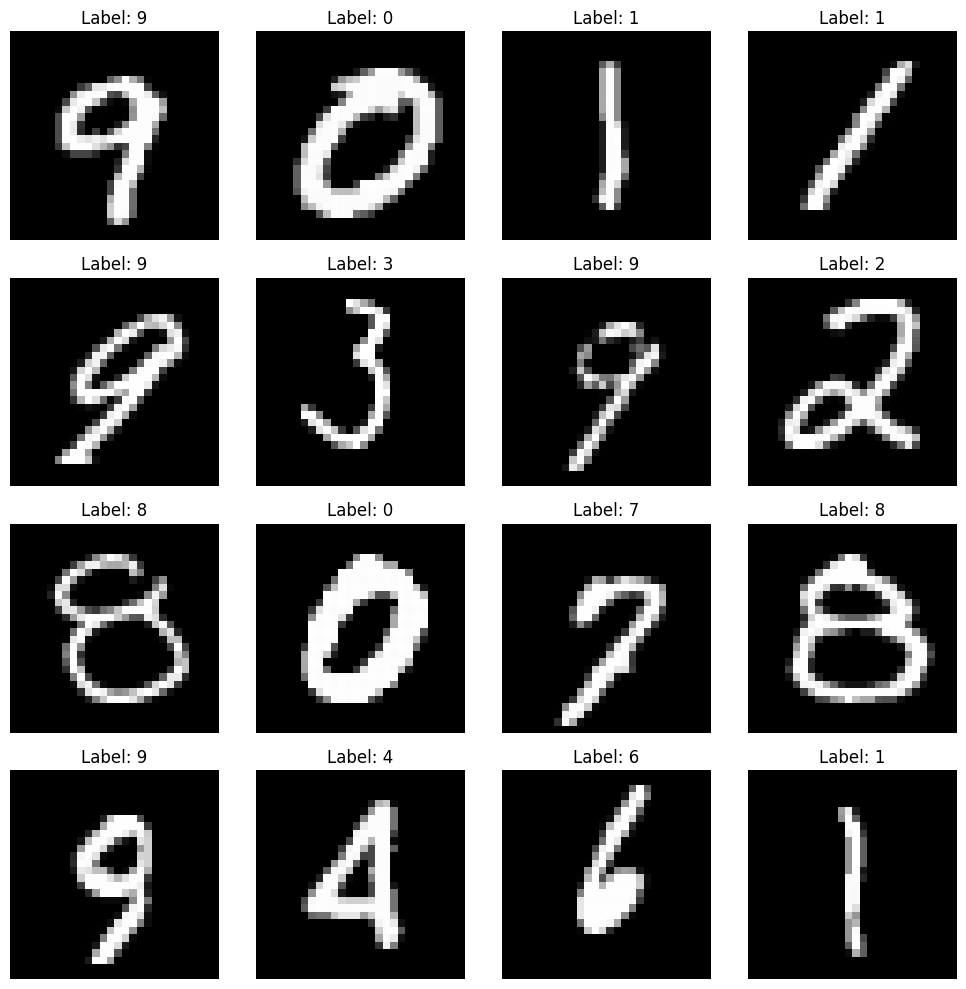

In [ ]:
# Get 16 random images from the training set
indices = torch.randint(0, len(trainset), (16,))
images = torch.stack([trainset[i][0] for i in indices])
labels = torch.tensor([trainset[i][1] for i in indices])

# Create a figure with a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Plot each image
for i, ax in enumerate(axes.flat):
    # Remove the normalization to display the images correctly
    img = images[i].squeeze().detach().cpu()
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Label: {labels[i].item()}')

plt.tight_layout()
plt.show()

All the images are also labeled 0-9. This means that we could do classification, i.e. learning $p(y | \mathbf{x})$, or conditional generation, $p(\mathbf{x} | y)$. However, the focus of this notebook will be unconditional generation, simply learning $p(\mathbf{x})$.

## Autoencoder

We will begin by defining the encoder and the decoder. The encoder takes our input, a black and white $28 \times 28$ pixel image, and converts it into a latent represententation $\mathbf{z} \in \R^h$, where $h$ is the hidden dimension size, a hyperparameter we can set. Recall that an autoencoder consist of an encoder, $E_{\theta}$, and a decoder, $D_{\phi}$. The encoder takes an input $\mathbf{x} \in \R^D$ and maps it to the latent representation $\mathbf{z} \in \R^h$, while the decoder maps the latent representation to our reconstructed input $\mathbf{\hat{x}} \in \R^D$

$$
\begin{align*}
    \mathbf{z} &= E_{\theta}(\mathbf{x}) \\
    \mathbf{\hat{x}} &= D_{\phi}(\mathbf{z})
\end{align*}
$$


### Problem 1: Implementing the Encoder and Decoder

In [ ]:
class AE_Encoder(nn.Module):
    def __init__(self, hidden_dim:int):
        super().__init__()
        # Define the layers of the encoder, and the non-linear function. We will only use linear layers.
        # Hint 1: the input to the first layer has dimensions (batch_size, 784)
        # Hint 2: you can add additional arguments to the __init__ method if you want
        #         specifying the number of units in each layer.
        ### START OF YOUR CODE ###
        # ~4 lines of code
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, hidden_dim)
        self.non_linearity = nn.ReLU()
        ### END OF YOUR CODE ###

    def forward(self, x):
        # Forward pass through the encoder. The input has dimensions (batch_size, 784).
        # Hint: the output should have dimensions (batch_size, hidden_dim).

        x = x.flatten(start_dim=1)  # (B, 1, 28, 28) -> (B, 784)

        ### START OF YOUR CODE ###
        # ~3 lines of code
        z = self.non_linearity(self.fc1(x))
        z = self.non_linearity(self.fc2(z))
        z = self.fc3(z)
        ### END OF YOUR CODE ###

        return z


In [ ]:
class AE_Decoder(nn.Module):
    def __init__(self, hidden_dim:int):
        super().__init__()
        # Define the layers of the decoder, and the non-linear function. We will only use linear layers.
        # Hint 1: the input has dimensions (batch_size, hidden_dim)
        # Hint 2: you can add additional arguments to the __init__ method if you want
        #         specifying the number of units in each layer.
        # Hint 3: the output should have dimensions (batch_size, 784)
        ### START OF YOUR CODE ###
        # ~4 lines of code
        self.fc1 = nn.Linear(hidden_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 784)
        self.non_linearity = nn.Sigmoid()
        ### END OF YOUR CODE ###

    def forward(self, z):
        # Forward pass through the decoder
        # Hint: the input has dimensions (batch_size, hidden_dim), and the output
        #       should have dimensions (batch_size, 784). We also want the output 
        #       to be between 0 and 1. What function can we use to achieve this?
        ### START OF YOUR CODE ###
        # ~4 lines of code
        x_hat = self.non_linearity(self.fc1(z))
        x_hat = self.non_linearity(self.fc2(x_hat))
        x_hat = self.fc3(x_hat)
        x_hat = torch.sigmoid(x_hat)
        ### END OF YOUR CODE ###

        return x_hat

We will now combine the encoder and decoder into an autoencoder.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, hidden_dim: int = 2, batch_size: int = 128):
        super().__init__()
        # Initialize the encoder and decoder. Remember to pass the hidden_dim to both.
        ### START OF YOUR CODE ###
        # ~2 lines of code
        self.encoder = AE_Encoder(hidden_dim)
        self.decoder = AE_Decoder(hidden_dim)
        ### END OF YOUR CODE ###

    def forward(self, x):
        # Implement the forward pass through the autoencoder.
        # We will return x_hat, the reconstructed input, 
        # and z, the latent representation.
        ### START OF YOUR CODE ###
        # ~2 lines of code
        z = self.encoder.forward(x)
        x_hat = self.decoder.forward(z)
        ### END OF YOUR CODE ###
        return x_hat, z

### Problem 2: Implementing MSE Loss

Given $N$ samples (our batch of data points) $\mathbf{X} = \left[ \mathbf{x}^{(1)}, \mathbf{x}^{(2)}, \dots, \mathbf{x}^{(N)} \right]$, and the corresponding batch of reconstructed input $\mathbf{\hat{X}} = \left[ \mathbf{\hat{x}}^{(1)}, \mathbf{\hat{x}}^{(2)}, \dots, \mathbf{\hat{x}}^{(N)} \right]$, the reconstruction loss is given by the average of the Mean Squared Error (MSE) over our batch

$$
\begin{align}
    \operatorname{MSE}(\mathbf{x}, \mathbf{\hat{x}}) &= \sum_{d=1}^D (\mathbf{x}_d - \mathbf{\hat{x}}_d)^2 \\
    \mathcal{L}_{\operatorname{rec}}(\mathbf{X}, \mathbf{\hat{X}}) &= \frac{1}{N} \sum_{i=1}^N \operatorname{MSE}(\mathbf{x}^{(i)}, \mathbf{\hat{x}}^{(i)}) \\
    &= \frac{1}{N} \sum_{i=1}^N \sum_{d=1}^D (\mathbf{x}_d^{(i)} - \mathbf{\hat{x}}_d^{(i)})^2 
\end{align}
$$

where $\mathbf{x}_d, \mathbf{\hat{x}}_d$ is the value for the pixel at position $d$ (in our case $D=28 \cdot 28 = 784$). This is already implemented in PyTorch, but for the purpose of learning, we want you to write your own.

**NB!** It is recommended to use the built-in functions in PyTorch as much as possible. For instance, you can use `torch.mean` or `torch.sum` to get the mean/sum value of a tensor! You can also specify which dimension you want to sum over, i.e. if `torch.sum(X, dim=1)` will sum over all the pixel values for each sample in the batch, but not sum over the batches. By default, these operations are applied to all dimensions. PyTorch already implements the MSE loss, but for the sake of learning you will implement it here.

In [ ]:
def custom_MSE_loss(x, x_hat):
    """
    MSE loss function as seen in Eq. (1-3).
    Args:
        x: the input. Size (N, D)
        x_hat: the reconstructed input. Size (N, D)
    Returns:
        The MSE loss. A scalar.
    """
    N, D = x_hat.shape
    ### START OF YOUR CODE ###
    # ~1 line of code
    mse_loss = ((x - x_hat) ** 2).sum() / N
    ### END OF YOUR CODE ###

    return mse_loss

x = torch.randn(10, 20)
x_hat = torch.randn(10, 20)

assert custom_MSE_loss(x, x_hat) - nn.MSELoss(reduction="sum")(x, x_hat) / x.shape[0] < 1e-6, "The custom MSE loss should be the same as the built-in MSE loss"
assert custom_MSE_loss(torch.tensor([[1.0, 2.0]]), torch.tensor([[1.0, 2.0]])) == 0.0, "The custom MSE loss should be 0.0 for equal values"
assert custom_MSE_loss(torch.tensor([[1.0, 2.0]]), torch.tensor([[1.0, 3.0]])) == 1.0, f"The custom MSE loss should be 1.0, was {custom_MSE_loss(torch.tensor([[1.0, 2.0]]), torch.tensor([[1.0, 3.0]]))}. Are you taking the mean over both dimensions?"

### Problem 3: Training the Model and Plotting Results

For your convenience, we have already implemented most of the training loop. However, there are still some choices you need to make. What should the learning rate be, and how many epochs should we train for? Additionally, it might be worth increasing the batch size if your memory allows it (on the other hand, if you get out-of-memory errors, try decreasing it). You can also play around with the size of the hidden dimension. However, once you are ready to move on, you should use `hidden_dim=2` as that allows us to nicely plot the latent representation.

100%|██████████| 5/5 [02:05<00:00, 25.16s/it]


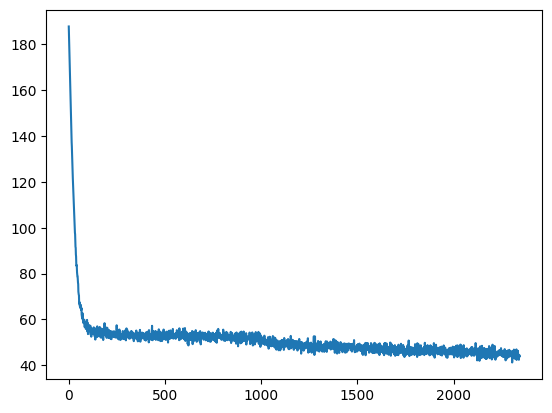

In [ ]:
### START OF YOUR CODE ###
# ~5 lines of code
loss_fn = custom_MSE_loss
learning_rate = 1e-4
batch_size = 128
hidden_dim = 2
num_epochs = 50
### END OF YOUR CODE ###

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

# Initialize the autoencoder
# NB! If you changed the __init__ method of the Autoencoder class, you need to change the initialization here as well.
autoencoder = Autoencoder(hidden_dim=hidden_dim).to(device)

# Initialize the optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
losses = []
# Train the autoencoder
for epoch in tqdm.trange(num_epochs):
    for x, y in trainloader:
        x = x.to(device)

        # Forward pass
        x_hat, z = autoencoder(x)
        x = x.reshape_as(x_hat)
        # Compute the loss
        loss = loss_fn(x, x_hat)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

plt.plot(losses)
plt.show()

We will now plot some reconstructed images from the test set.

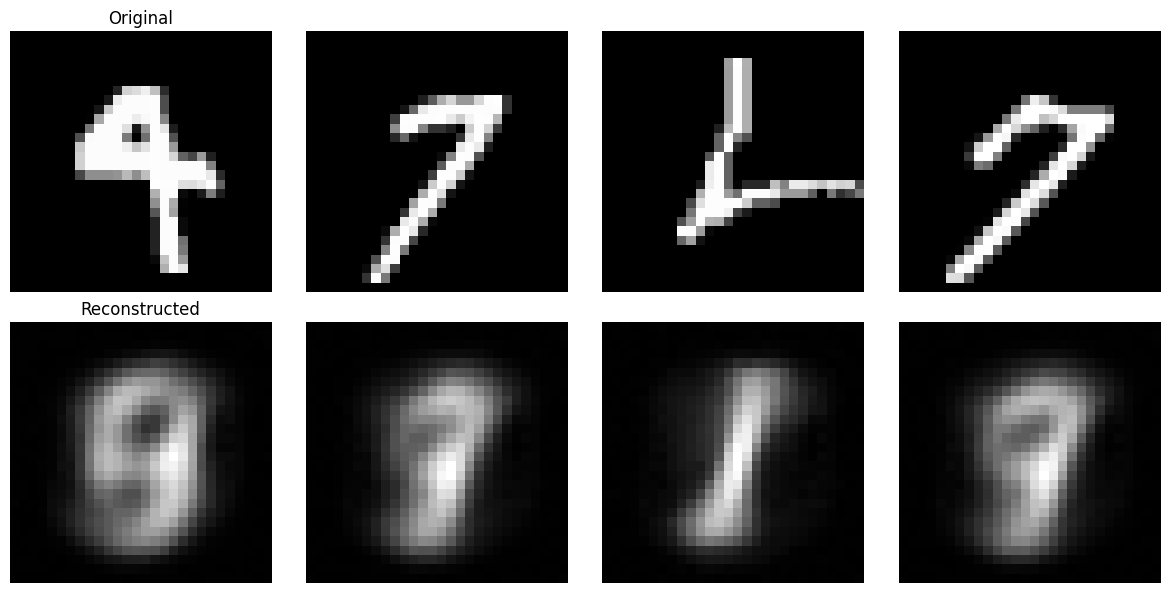

In [ ]:
# Get some test images
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)
x, _ = next(iter(testloader))
x = x.to(device)
x_flat = x.flatten(start_dim=1)

# Get reconstructions
with torch.no_grad():
    x_hat, _ = autoencoder(x_flat)
    x_hat = x_hat.reshape(x.shape)


# Plot original and reconstructed images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    # Plot original
    axes[0,i].imshow(x[i].cpu().squeeze(), cmap='gray')
    axes[0,i].axis('off')
    if i == 0:
        axes[0,i].set_title('Original')
    
    # Plot reconstruction
    axes[1,i].imshow(x_hat[i].cpu().squeeze(), cmap='gray')
    axes[1,i].axis('off')
    if i == 0:
        axes[1,i].set_title('Reconstructed')

plt.tight_layout()
plt.show()


Finally, we will plot the latent representations of the autoencoder. Note that if your hidden dimension is larger than 2, you will need to perform some dimensionality reduction technique before plotting the latent representation (we're using [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)).

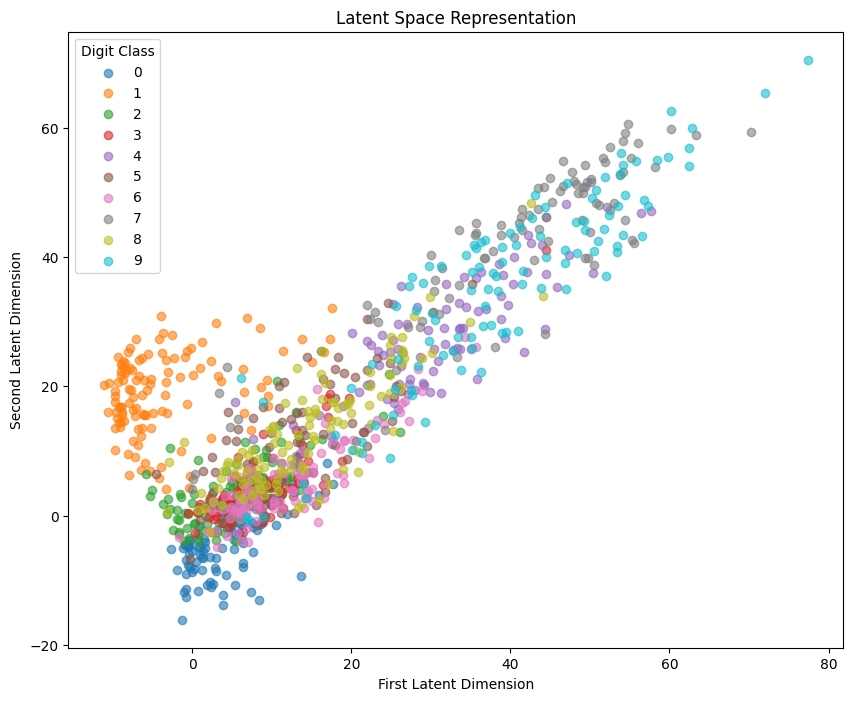

In [ ]:
# Get a larger batch of test images
N = 1000
testloader = torch.utils.data.DataLoader(testset, batch_size=N, shuffle=True)
x, y = next(iter(testloader))
x = x.to(device)
x_flat = x.flatten(start_dim=1)

# Get latent representations
with torch.no_grad():
    _, z = autoencoder(x_flat)

# Convert to numpy for plotting
z = z.cpu().numpy()
y = y.numpy()

# If the latent space is higher than 2 dimensions, we reduce it to 2 dimensions using t-SNE
if z.shape[1] > 2:
    from sklearn.manifold import TSNE
    print("Reducing latent space to 2 dimensions using t-SNE...")
    z = TSNE(n_components=2, random_state=42).fit_transform(z)

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter_plots = []
for digit in range(10):
    mask = y == digit
    scatter = plt.scatter(z[mask, 0], z[mask, 1], alpha=0.6, label=str(digit))
    scatter_plots.append(scatter)

plt.xlabel('First Latent Dimension')
plt.ylabel('Second Latent Dimension')
plt.title('Latent Space Representation')
plt.legend(title='Digit Class')
plt.show()


We will now sample points in latent space and reconstruct images from them (**NB!**: for this cell to run, you need to train a model with `hidden_dim=2`)

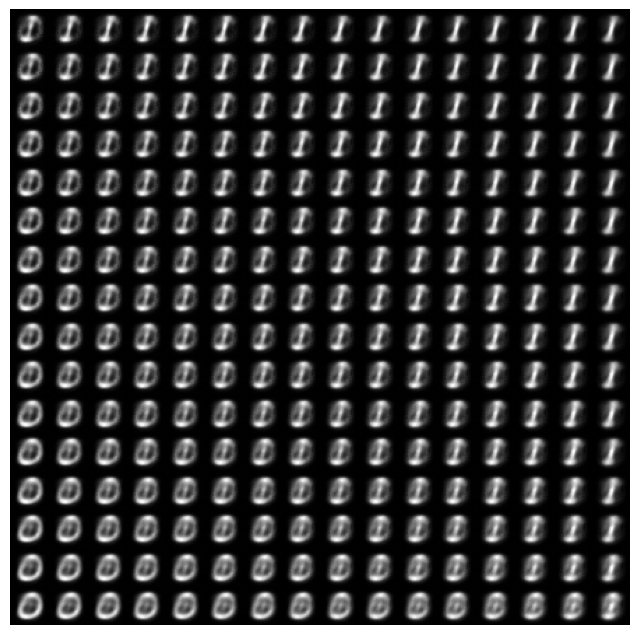

In [ ]:
import numpy as np
from pprint import pprint

# Number of steps in each direction
n_steps = 16

# Create a grid of points between 0.01 and 0.99
x = torch.linspace(0.01, 0.99, n_steps)
y = torch.linspace(0.01, 0.99, n_steps)

# Create a grid of points
grid_points = torch.zeros(n_steps * n_steps, 2)

# Create meshgrid of points
X, Y = torch.meshgrid(x, y, indexing='ij')

# Convert to standard normal values using inverse CDF (probit function)
from scipy.stats import norm
X = torch.tensor(norm.ppf(X.numpy().astype(np.float32)))
Y = torch.tensor(norm.ppf(Y.numpy().astype(np.float32)))

# Combine into grid points
grid_points = torch.stack([X.flatten(), Y.flatten()], dim=1).float().to(device)


# Generate images from the latent points
with torch.no_grad():
    autoencoder.eval()
    generated = autoencoder.decoder(grid_points)
    generated = generated.reshape(-1, 1, 28, 28)

# Plot the grid
fig, axes = plt.subplots(n_steps, n_steps, figsize=(8, 8))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(n_steps):
    for j in range(n_steps):
        axes[i,j].imshow(generated[i * n_steps + j].cpu().squeeze(), cmap='gray')
        axes[i,j].axis('off')

plt.show()


While the image reconstruction often yields recognizable images, the latent space is not very structured. For latent spaces in higher dimensions, this is an even bigger problem. One problem that you should observe is that we are not seeing all the classes (digits), but only a subset. To improve the diversity and sample quality, we will now implement the Variational Autoencoder.

## Variational Autoencoder

Next, we will implement a variational autoencoder (VAE). It is similar to the standard autoencoder in that it has an encoder and a decoder and uses the reconstruction loss to optimize our parameters. However, this model also imposes some restrictions on the latent space. Namely, we want our latent space to be a Gaussian distribution, i.e. $\mathbf{z} \sim \mathcal{N}(\mu, \sigma^2)$.

### The Evidence Lower Bound (ELBO)

We will optimize our model using the ELBO objective given by

$$
\operatorname{ELBO}(\theta, \phi) = \mathbb{E}_{\mathbf{z} \sim q_{\theta}(\mathbf{z} | \mathbf{x})} \left[ \log p_{\phi}(\mathbf{x} | \mathbf{z}) \right] - \operatorname{KL} \left[ q_{\theta}(\mathbf{z} | \mathbf{x}) || p(\mathbf{z}) \right]
$$

where $q_{\theta}(\mathbf{z} | \mathbf{x})$ is the distribution over our latent space defined by our encoder, $p(\mathbf{x} | \mathbf{z})$ is the distribution over our reconstructed data given by our decoder and $p(\mathbf{z})$ is the distribution we want our latent space to follow. We can choose $p(\mathbf{z})$ from a wide family of distributions, but normally we set $p(\mathbf{z}) = \mathcal{N}(0, 1)$.

The first part of the equation is simply another way to write the reconstructions loss, which we previously used the Mean Squared Error loss for. The last part is the KL-divergence, which measures how far away two distributions are from each other. 

<!-- Most optimizers try to *minimize* an objective, so our final loss function is therefore defined by

$$
\begin{align*}
\mathcal{L}(\theta, \phi)  &= -\operatorname{ELBO}(\theta, \phi)  \\
&= - \mathbb{E}_{\mathbf{z} \sim q_{\theta}(\mathbf{z} | \mathbf{x})} \left[ \log p_{\phi}(\mathbf{x} | \mathbf{z}) \right] + \operatorname{KL} \left[ q_{\theta}(\mathbf{z} | \mathbf{x}) || p(\mathbf{z}) \right]
\end{align*}
$$ -->

To further simplify, we assume that: (1) $q_{\theta}(\mathbf{z} | \mathbf{x})$ and $p(\mathbf{z})$ are both Gaussian distributions and (2) all elements of the covariance matrix of $q$ are zero, except for along the diagonal. Property (2) means that all the dimensions of the distribution are uncorrelated, and since it is a Gaussian, also independent. We will later see how we satisfy these conditions when implementing the VAE. If we additionally set $p(\mathbf{z}) = \mathcal{N}(0, 1)$, we can write down the KL divergence in a simpler form. If our latent distribution $q$ has $J$ dimensions, and the mean and variance of dimension $j$ is denoted $\mu_j, \sigma^2_j$, then we have that

$$
\begin{align*}
    \operatorname{KL}\left[ q_{\theta}(\mathbf{z} | \mathbf{x}) || p(\mathbf{z}) \right] &= \operatorname{KL}\left[ q_{\theta}(\mathbf{z} | \mathbf{x}) ||  \mathcal{N}(0, 1) \right] \\
    &= - \frac{1}{2} \sum_{j=1}^J \left[ 1 + \log \sigma_j^2 - \sigma_j^2 - \mu_j^2  \right]
\end{align*}
$$

By combining the simplified KL-divergence and using the fact that the reconstruction loss can be expressed as the Mean Sqaure Error, we get a final loss (notice that we have flipped the sign since we want to minimize the objective, not maximize it):

$$
\begin{align*}
    \mathcal{L}_{\operatorname{VAE}}(\theta, \phi)  &= -\operatorname{ELBO}(\theta, \phi) \\
    &= \mathcal{L}_{\operatorname{rec}}(\mathbf{x}, \mathbf{\hat{x}}) + \operatorname{KL}(\sigma, \mu) \\
    &= \sum_{d=1}^{D} (x_{d} - \hat{x}_{d})^2 - \frac{1}{2} \sum_{j=1}^J \left[ 1 + \log \sigma_j^2 - \sigma_j^2 - \mu_j^2  \right] 
\end{align*}
$$

where $D$ is the dimensionality of our input data (in our case $28 \cdot 28 = 784$), and $J$ is the dimensioality of our latent space (`hidden_dim`). Again, however, we will use the batched loss given by taking the mean over our $N$ data points.

$$
\begin{align*}
    \mathcal{L}_{\operatorname{batched\_VAE}}  &= \frac{1}{N} \sum_{i=1}^N \left[ \mathcal{L}_{\operatorname{rec}}(\mathbf{x^{(i)}}, \mathbf{\hat{x}^{(i)}}) + \operatorname{KL}(\log \sigma^{(i)}, \mu^{(i)}) \right] \\
    &= \frac{1}{N} \sum_{i=1}^N \left[ \sum_{d=1}^{D} (x_{d}^{(i)} - \hat{x}^{(i)}_d)^2 - \frac{1}{2} \sum_{j=1}^J \left[ 1 + \log (\sigma_j^{(i)})^2 - (\sigma_j^{(i)})^2 - (\mu_j^{(i)})^2  \right] \right] \\
    &= \underbrace{\frac{1}{N} \sum_{i=1}^N \sum_{d=1}^{D} (x_{d}^{(i)} - \hat{x}^{(i)}_d)^2}_{\text{reconstruction loss}} +  \underbrace{\left(-\frac{1}{2 N} \sum_{i=1}^N \sum_{j=1}^J \left[ 1 + \log (\sigma_j^{(i)})^2 - (\sigma_j^{(i)})^2 - (\mu_j^{(i)})^2  \right]\right)}_{\text{KL divergence}}
\end{align*}
$$

Note that the subscript operator is overloaded and that $(\sigma^{(i)})^2$ does not mean $\sigma^{2i}$, but rather variance for the i-th data point.

### Problem 4: Implementing the VAE Loss

Try to implement the loss function down below. For the reconstruction loss, you can reuse your earlier implementation or use the built-in `F.mse_loss()`.

In [ ]:
import torch.nn.functional as F
import torch

def loss_fn(x_hat, x, mean, log_var):
    """
    Custom loss function that computes the VAE loss.
    Args:
        x_hat: the reconstructed input. Dimensions (batch_size, 784)
        x: the original input. Dimensions (batch_size, 784)
        mean: the mean of the latent distribution. Dimensions (batch_size, hidden_dim)
        log_var: the log of the variance of the latent distribution. Dimensions (batch_size, hidden_dim)
    Returns:
        The VAE loss. A scalar.
        The reconstruction loss. A scalar.
        The KL-divergence. A scalar.
    """
    # Here, you should implement the batched VAE loss as described above. 
    # It is important that you normalize the reconstruction loss and the KL-divergence
    # by the same factor.
    N, D = x_hat.shape
    ### START OF YOUR CODE ###
    # ~2 lines of code
    reconstruction_loss =  1 / N * torch.sum((x - x_hat) ** 2)
    kl_loss = -1/(2*N) * torch.sum(1 + log_var - log_var.exp() - mean.pow(2))
    ### END OF YOUR CODE ###
    return reconstruction_loss + kl_loss, reconstruction_loss, kl_loss

### Problem 5: Implementing the VAE

We will now construct an encoder and a decoder. They will look a lot like the basic autoencoder. The output of the encoder should be the mean and variance of our latent distribution. Since we assumed that each dimension in our latent distribution is independent, we only need to output the diagonal of the covariance matrix $\Sigma$. We denote this $\sigma^2$. We will not output the variance directly, but rather the log of the variance $\log \sigma^2$.

In [ ]:
class VAE_Encoder(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        # Define the layers of the encoder, and the non-linear function to use between them.
        # Hint 1: the input to the first layer has dimensions (batch_size, 784)
        # Hint 2: you can add additional arguments to the __init__ method if you want
        #         specifying the number of units in each layer.
        # Hint 3: we need a separate final layer for the mean and the log variance of the latent space.
        ### START OF YOUR CODE ###
        # ~6 lines of code
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.non_linearity = nn.ReLU()
        self.fc_mean = nn.Linear(128, hidden_dim)       # Should have dimensions (batch_size, hidden_dim)   
        self.fc_log_var = nn.Linear(128, hidden_dim)    # Should have dimensions (batch_size, hidden_dim)      
        ### END OF YOUR CODE ###

    def forward(self, x):
        # Forward pass through the encoder. The input has dimensions (batch_size, 784).
        # Hint: the output should have dimensions (batch_size, hidden_dim).
        x = x.flatten(start_dim=1)

        ### START OF YOUR CODE ###
        # ~5 lines of code
        z = self.non_linearity(self.fc1(x))
        z = self.non_linearity(self.fc2(z))
        z = self.non_linearity(self.fc3(z))
        mean = self.fc_mean(z)
        log_var = self.fc_log_var(z)
        ### END OF YOUR CODE ###

        return mean, log_var


In [ ]:
class VAE_Decoder(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        # Define the layers of the decoder, and the non-linear function to use between them.
        # Hint 1: the input has dimensions (batch_size, hidden_dim)
        # Hint 2: you can add additional arguments to the __init__ method if you want
        #         specifying the number of units in each layer.
        ### START OF YOUR CODE ###
        # ~5 lines of code
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 784)
        self.non_linearity = nn.ReLU()
        ### END OF YOUR CODE ###

    def forward(self, z):
        # Forward pass through the decoder
        # Hint: the input has dimensions (batch_size, hidden_dim), and the output
        #       should have dimensions (batch_size, 784). We also want the output 
        #       to be between 0 and 1. What function can we use to achieve this?
        ### START OF YOUR CODE ###
        # ~4 lines of code
        x_hat = self.non_linearity(self.fc1(z))
        x_hat = self.non_linearity(self.fc2(x_hat))
        x_hat = self.non_linearity(self.fc3(x_hat))
        x_hat = torch.sigmoid(self.fc4(x_hat))
        ### END OF YOUR CODE ###

        return x_hat

### Helper function (sampling from the latent space)

We also need to write a helper function to convert our mean and log-variance vectors into a sample from our latent distribution. Recall that we use the reparametrization trick and sample $\epsilon \sim \mathcal{N}(0, 1)$. The function that converts our $\epsilon \sim \mathcal{N}(0, 1)$ into our final sample $\mathrm{z} \sim \mathcal{N}(\mu, \mathrm{diag}(\sigma^2))$ is given by

$$
\begin{align*}
    \mathbf{z} &= \mu + \epsilon * \mathrm{e}^{0.5 \cdot \log \sigma^2} \\
    &= \mu + \epsilon * \sigma
\end{align*}
$$

From the equation, we can see that $\mathbf{z}$ follows a normal distribution with a mean of $\mu$ and a variance of $\sigma^2$.

In [ ]:
def reparametrize(mean, log_var):
    """
    Reparametrization trick to sample from a Gaussian distribution.
    Should return a sample from the distribution with mean `mean` and variance `log_var.exp()`.
    """
    epsilon = torch.randn_like(mean)
    return mean + torch.exp(0.5 * log_var) * epsilon

### Problem 6: Putting It All Together & Training

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, hidden_dim: int = 2):
        super().__init__()
        # Initialize the encoder and decoder.
        
        self.hidden_dim = hidden_dim    # We will need this when sampling from the latent space

        ### START OF YOUR CODE ###
        # ~2 lines of code
        self.encoder = VAE_Encoder(hidden_dim)
        self.decoder = VAE_Decoder(hidden_dim)
        # self.encoder = VAE_Conv_Encoder(hidden_dim)
        # self.decoder = VAE_Conv_Decoder(hidden_dim)

        ### END OF YOUR CODE ###

    def forward(self, x):
        # Implement the forward pass through the autoencoder.
        # First, we pass the input through the encoder to get the mean and log variance of the latent distribution.
        # Then, we sample from the latent distribution using the reparametrization trick.
        # Finally, we pass the sampled latent representation through the decoder to get the reconstructed input.
        # We will return x_hat, the reconstructed input, 
        # and z, the latent representation.
        ### START OF YOUR CODE ###
        # ~3 lines of code
        mean, log_var = self.encoder.forward(x)
        z = reparametrize(mean, log_var)
        x_hat = self.decoder.forward(z)

        ### END OF YOUR CODE ###
        return x_hat, z, mean, log_var
    

    def generate(self, num_samples: int = 1):
        """
        Generate a sample from the latent distribution.
        """

        z = torch.randn(num_samples, self.hidden_dim)
        return self.decoder(z)
    
    def reconstruct(self, x):
        """
        Reconstruct the input.
        """
        return self.forward(x)[0]

In [ ]:
### START OF YOUR CODE ###

loss_fn = loss_fn
learning_rate = 1e-4
batch_size = 128
hidden_dim = 2
num_epochs = 50

### END OF YOUR CODE ###
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

# Initialize the autoencoder
# NB! If you changed the __init__ method of the Autoencoder class, you need to change the initialization here as well.
vae = VariationalAutoencoder(hidden_dim=hidden_dim).to(device)

# Initialize the optimizer
optimizer = torch.optim.AdamW(vae.parameters(), lr=learning_rate)
losses = []
reconstruction_losses = []
kl_losses = []
# Train the autoencoder
for epoch in tqdm.trange(num_epochs):
    for x, y in trainloader:
        x = x.to(device)

        # Forward pass
        x_hat, _, mean, log_var = vae(x)

        # Compute the loss
        x = x.reshape_as(x_hat)
        loss, reconstruction_loss, kl_loss = loss_fn(x_hat, x, mean, log_var)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        reconstruction_losses.append(reconstruction_loss.item())
        kl_losses.append(kl_loss.item())

plt.plot(losses)
plt.plot(reconstruction_losses)
plt.plot(kl_losses)
plt.legend(["Loss", "Reconstruction Loss", "KL Loss"])
plt.show()

 12%|█▏        | 6/50 [02:40<20:09, 27.49s/it]

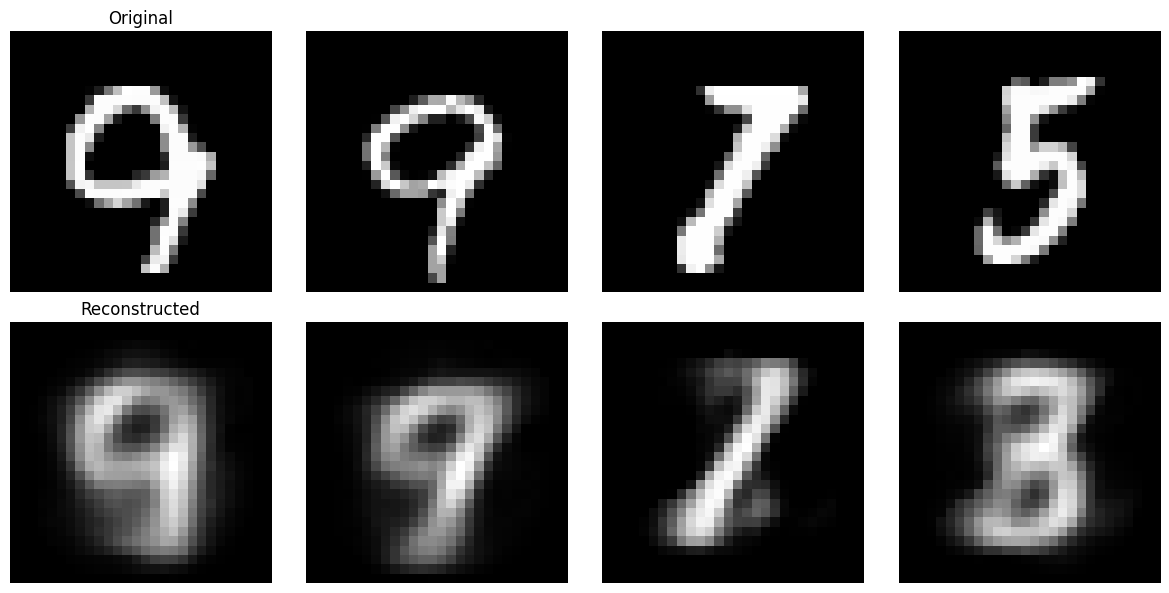

In [ ]:
# Get some test images
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)
x, _ = next(iter(testloader))
x = x.to(device)

# Get reconstructions
with torch.no_grad():
    vae.eval()
    x_hat, _, _, _ = vae(x)
    x_hat = x_hat.reshape(x.shape)


# Plot original and reconstructed images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    # Plot original
    axes[0,i].imshow(x[i].cpu().squeeze(), cmap='gray')
    axes[0,i].axis('off')
    if i == 0:
        axes[0,i].set_title('Original')
    
    # Plot reconstruction
    axes[1,i].imshow(x_hat[i].cpu().squeeze(), cmap='gray')
    axes[1,i].axis('off')
    if i == 0:
        axes[1,i].set_title('Reconstructed')

plt.tight_layout()
plt.show()

Let's plot the 1000 samples in the latent space, like we did for the normal autoencoder.

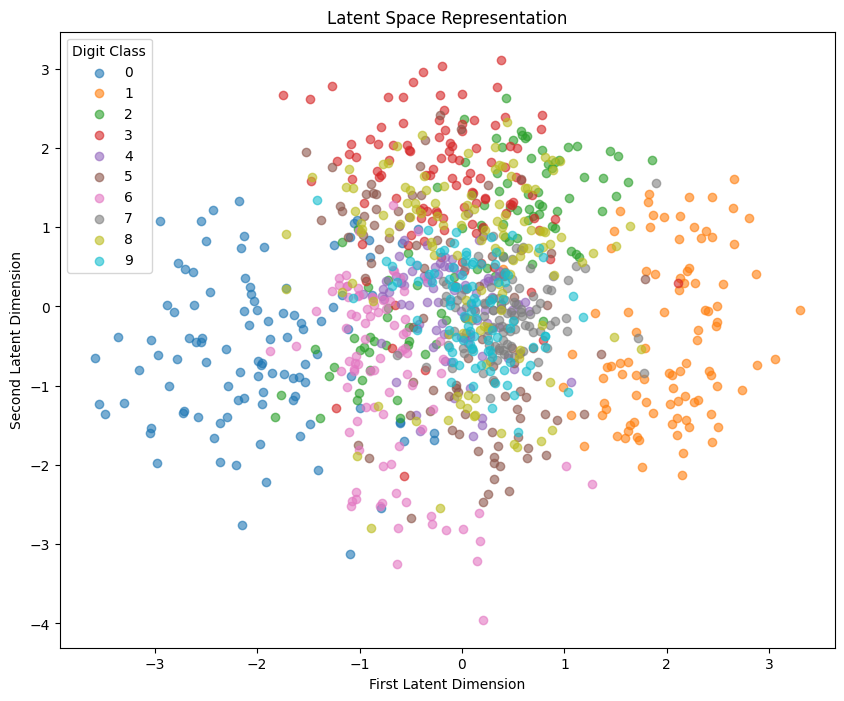

In [ ]:
# Get a larger batch of test images
N = 1000
testloader = torch.utils.data.DataLoader(testset, batch_size=N, shuffle=True)
x, y = next(iter(testloader))
x = x.to(device)

# Get latent representations
with torch.no_grad():
    _, z, _, _ = vae(x)

# Convert to numpy for plotting
z = z.cpu().numpy()
y = y.numpy()

# If the latent space is higher than 2 dimensions, we reduce it to 2 dimensions using t-SNE
if z.shape[1] > 2:
    print("Using t-SNE to reduce dimensions to 2...")
    from sklearn.manifold import TSNE
    z = TSNE(n_components=2, random_state=42).fit_transform(z)

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter_plots = []
for digit in range(10):
    mask = y == digit
    scatter = plt.scatter(z[mask, 0], z[mask, 1], alpha=0.6, label=str(digit))
    scatter_plots.append(scatter)

plt.xlabel('First Latent Dimension')
plt.ylabel('Second Latent Dimension')
plt.title('Latent Space Representation')
plt.legend(title='Digit Class')
plt.show()

One cool thing we can do since this model is explicit, is interpolate between points. The code below samples 4 random points and interpolates in a grid between them. Then we can see how one digit might morph into another gradually! (**NB!: for this cell to run, you need to have a VAE with `hidden_dim=2`)

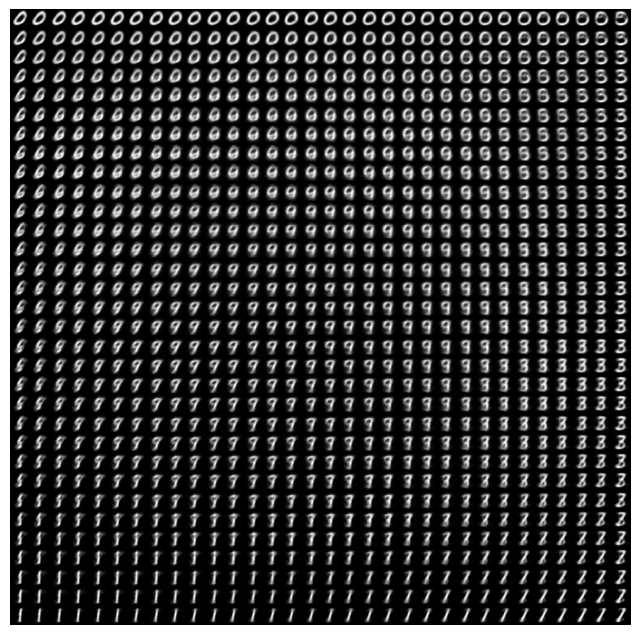

In [ ]:
import numpy as np
from pprint import pprint

# Number of steps in each direction
n_steps = 32

# Create a grid of points between 0.01 and 0.99
x = torch.linspace(0.01, 0.99, n_steps)
y = torch.linspace(0.01, 0.99, n_steps)

# Create a grid of points
grid_points = torch.zeros(n_steps * n_steps, 2)

# Create meshgrid of points
X, Y = torch.meshgrid(x, y, indexing='ij')

# Convert to standard normal values using inverse CDF (probit function)
from scipy.stats import norm
X = torch.tensor(norm.ppf(X.numpy().astype(np.float32)))
Y = torch.tensor(norm.ppf(Y.numpy().astype(np.float32)))

# Combine into grid points
grid_points = torch.stack([X.flatten(), Y.flatten()], dim=1).float().to(device)


# Generate images from the latent points
with torch.no_grad():
    vae.eval()
    generated = vae.decoder(grid_points)
    generated = generated.reshape(-1, 1, 28, 28)

# Plot the grid
fig, axes = plt.subplots(n_steps, n_steps, figsize=(8, 8))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(n_steps):
    for j in range(n_steps):
        axes[i,j].imshow(generated[i * n_steps + j].cpu().squeeze(), cmap='gray')
        axes[i,j].axis('off')

plt.show()

If everything went well, you should see clearly recognizable digits (although they might be a bit blurry). Additionally, you should see all digits from 0 to 9 represented in the plot.